In [53]:
# Import libraries
import os
import numpy as np
import cv2
import random
import pandas as pd
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread, imshow

from glob import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.preprocessing.image import img_to_array, load_img

### Data Preprocessing
Loop through the data directory and read the images in the three folders normal, benign, malignant.
After that the images are divided into a train, validation and test data set.

In [58]:
#
data_dir = '/content/drive/MyDrive/SpicedAcademy/PrediCare_BreastCancerPrediction/data/Dataset_BUSI_with_GT/Original without duplicated, misclassification and axila/balanced_data'

def read_data(data_dir):
  # Initialize lists for images, mask, labels
  images = []
  masks = []
  labels = []
  classes = {'normal': 0, 'benign': 1, 'malignant' : 2}

  for class_name, class_label in classes.items():
      class_dir = os.path.join(data_dir, class_name)
      for image_file in os.listdir(class_dir):
          if image_file.endswith(".png") and 'mask' not in image_file:
              # Load the original image
              image_path = os.path.join(class_dir, image_file)
              images.append(image_path)

              # Find all masks associated with the image
              image_name = os.path.splitext(image_file)[0]# Remove the file extension
              matching_masks = [f for f in os.listdir(class_dir) if f == image_name + '_mask.png']
              for mask_file in matching_masks:
                mask_path = os.path.join(class_dir, mask_file)
                masks.append(mask_path)

              class_label = classes[class_name]
              labels.append(class_name)

  return images, masks, labels


In [59]:
images, masks, labels = read_data(data_dir)

In [60]:
print(len(images))
print(len(masks))
print(len(labels))

894
894
894


In [61]:
# Creating dataframe from the generated lists
df = pd.DataFrame({'images': images, 'masks': masks, 'labels': labels})

train_data, test_data = train_test_split(df, test_size = 0.2, random_state=42, stratify=df['labels'])
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
#val_data, test_data = train_test_split(test_data, test_size = 0.5, random_state=42, stratify=df['labels'])

In [62]:
height, width, channels = 128, 128, 3

# Initialize empty arrays for X_train and y_train
X_train = np.zeros((len(train_data), height, width, channels), dtype=np.uint8)
y_train = np.zeros((len(train_data), height, width, 1), dtype=np.bool)

# Iterate through the DataFrame to populate X_train and y_train
for idx, row in train_data.iterrows():
    image_path = row['images']
    mask_path = row['masks']

    # Load and resize the image
    image = cv2.imread(image_path)
    image = cv2.resize(image, (width, height))

    # Load and resize the mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (width, height))
    mask = np.expand_dims(mask, axis=-1)  # Expand dimensions to make it (height, width, 1)

    X_train[idx] = image
    y_train[idx] = mask

<ipython-input-62-a1c8a5a9486a>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_train = np.zeros((len(train_data), height, width, 1), dtype=np.bool)


In [63]:
height, width, channels = 128, 128, 3

# Initialize empty arrays for X_train and y_train
X_test = np.zeros((len(test_data), height, width, channels), dtype=np.uint8)
y_test = np.zeros((len(test_data), height, width, 1), dtype=np.bool)

# Iterate through the DataFrame to populate X_test and y_test
for idx, row in test_data.iterrows():
    image_path = row['images']
    mask_path = row['masks']

    # Load and resize the image
    image = cv2.imread(image_path)
    image = cv2.resize(image, (width, height))

    # Load and resize the mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (width, height))
    mask = np.expand_dims(mask, axis=-1)  # Expand dimensions to make it (height, width, 1)

    X_test[idx] = image
    y_test[idx] = mask

<ipython-input-63-fde9166e1291>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_test = np.zeros((len(test_data), height, width, 1), dtype=np.bool)


In [64]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(715, 128, 128, 3)
(715, 128, 128, 1)
(179, 128, 128, 3)
(179, 128, 128, 1)


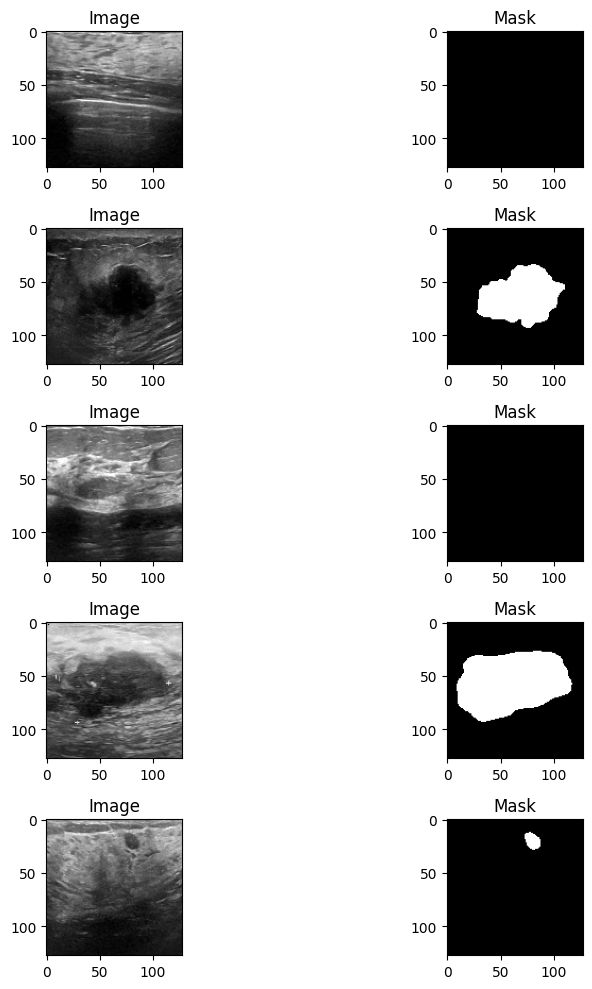

In [65]:

# Define the number of samples you want to plot
num_samples_to_plot = 5

# Create subplots for the images and their corresponding masks
fig, axes = plt.subplots(num_samples_to_plot, 2, figsize=(10, 10))

for i in range(num_samples_to_plot):
    # Randomly select an index from X_train and y_train
    idx = np.random.randint(0, len(X_train))

    # Get the image and mask
    image = X_train[idx]
    mask = y_train[idx]

    # Plot the image
    axes[i, 0].imshow(image)
    axes[i, 0].set_title("Image")

    # Plot the mask
    axes[i, 1].imshow(mask[:, :, 0], cmap='gray')
    axes[i, 1].set_title("Mask")

# Adjust spacing between subplots
plt.tight_layout()
plt.show()

### Seeding

In [66]:
os.environ['PYTHONHASHSEED'] = str(42)
np.random.seed(42)
tf.random.set_seed(42)


### Hyperparameters

In [67]:
batch_size = 8
learning_rate = 0.0001
epochs = 100
height = 128
width = 128
channels = 3

### U-Net
Defining the architecture of the U-Net model

#### Callback
Checkpoints: save the model in case something goes wrong, not lose all calculation
Useful what is the exact number of epochs: find a balance between under and overfitting by having too less or too many epochs --> use EarlyStopping
TensorBoard: Visualizing tool, graphical interface shows how loss goes with epochs etc..

In [68]:
# Defining input layer and convert it to a floating naumber
inputs = tf.keras.layers.Input((width, height, channels))

s = tf.keras.layers.Lambda(lambda x: x/255)(inputs)

# Contracting Path/Encoder
# Dropout Layers to avoid overfitting
c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding = 'same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding = 'same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding = 'same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding = 'same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding = 'same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding = 'same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding = 'same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding = 'same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding = 'same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding = 'same')(c5)

# Expansive Path/Decoder
u6 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides = (2,2), padding = 'same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides = (2,2), padding = 'same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides = (2,2), padding = 'same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides = (2,2), padding = 'same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis =3)
c9 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid')(c9)


In [69]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics= ['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 lambda_3 (Lambda)           (None, 128, 128, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv2d_41 (Conv2D)          (None, 128, 128, 16)         448       ['lambda_3[0][0]']            
                                                                                                  
 dropout_20 (Dropout)        (None, 128, 128, 16)         0         ['conv2d_41[0][0]']           
                                                                                            

In [70]:
# Callbacks
checkpointer = tf.keras.callbacks.ModelCheckpoint('unet_for_segmentation.h5', verbose = 1, save_best_only=True)
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs') # need to modify
]

In [71]:
results = model.fit(X_train, y_train, validation_split=0.1, batch_size=batch_size, epochs = epochs, callbacks=callbacks)

Epoch 1/100
81/81 [==============================] - 119s 1s/step - loss: 0.3071 - accuracy: 0.9076 - val_loss: 0.2408 - val_accuracy: 0.9399
Epoch 2/100
81/81 [==============================] - 115s 1s/step - loss: 0.2395 - accuracy: 0.9189 - val_loss: 0.1761 - val_accuracy: 0.9399
Epoch 3/100
81/81 [==============================] - 116s 1s/step - loss: 0.2287 - accuracy: 0.9189 - val_loss: 0.1797 - val_accuracy: 0.9399
Epoch 4/100
81/81 [==============================] - 120s 1s/step - loss: 0.2210 - accuracy: 0.9189 - val_loss: 0.2106 - val_accuracy: 0.9399
Epoch 5/100
81/81 [==============================] - 118s 1s/step - loss: 0.2131 - accuracy: 0.9208 - val_loss: 0.1710 - val_accuracy: 0.9428
Epoch 6/100
81/81 [==============================] - 122s 2s/step - loss: 0.1946 - accuracy: 0.9277 - val_loss: 0.1720 - val_accuracy: 0.9463
Epoch 7/100
81/81 [==============================] - 120s 1s/step - loss: 0.1871 - accuracy: 0.9327 - val_loss: 0.2060 - val_accuracy: 0.9487
Epoch 

In [73]:
idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose =1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose =1)
preds_test = model.predict(X_test, verbose =1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

6/6 [==============================] - 9s 2s/step


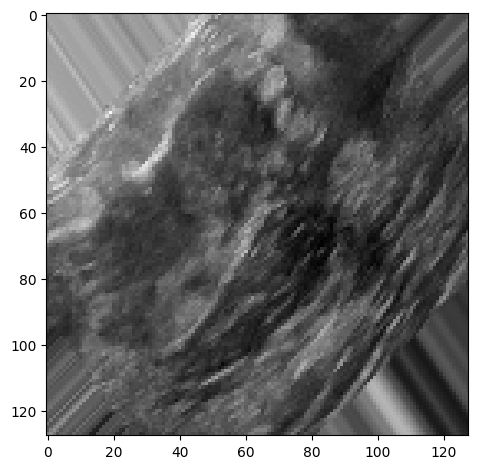

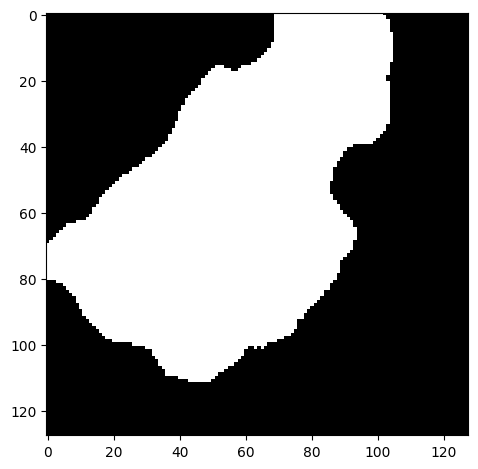

/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


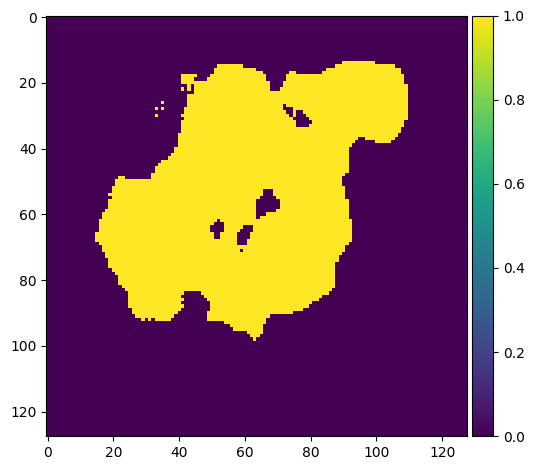

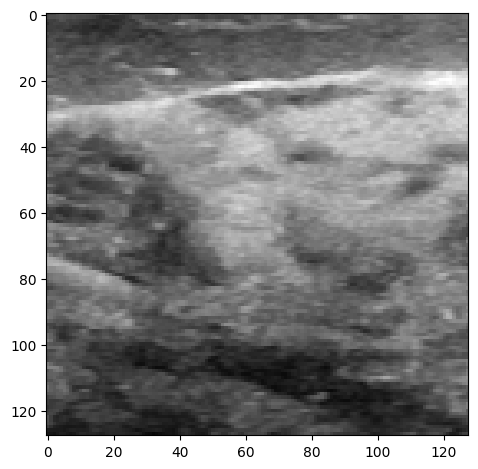

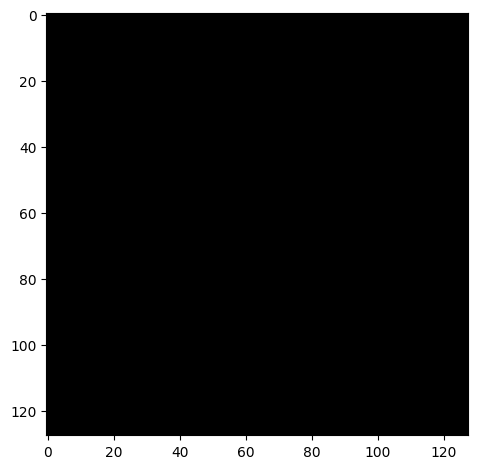

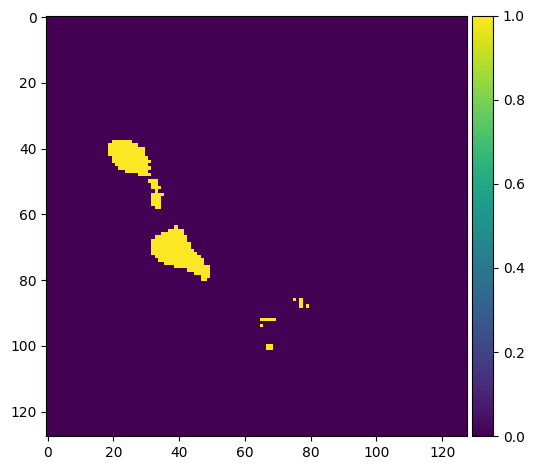

In [74]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9): ][ix])
plt.show()
imshow(np.squeeze(y_train[int(y_train.shape[0]*0.9): ][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

